In [1]:
# defining the version of tensor flow
%tensorflow_version 2.x

# importing the modules to be used
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import sklearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error



import requests
import json


In [2]:
# fetch data using http request from materials project

pload = {
    'criteria': {
        'piezo': {'$ne':None}
    },
    'properties': [
        'nelements',
        'energy',
        'nsites',
        'volume',
        'energy_per_atom',
        'density',
        'band_gap.search_gap.band_gap',
        'band_gap.search_gap.is_direct',
        'piezo',
        'e_above_hull',
        'is_compatible',
        'spacegroup.crystal_system',
        'spacegroup.point_group',
        'unit_cell_formula',
        'diel.poly_electronic',
        'diel.poly_total',
        'elasticity.poisson_ratio',
        'elasticity.universal_anisotropy',
        'total_magnetization',
        'elasticity_third_order.average_linear_thermal_expansion',
        'elasticity_third_order.debye_temperature',
        'elasticity_third_order.homogeneous_poisson',
        'efermi',
        'final_energy',
        'final_energy_per_atom',
        'formation_energy_per_atom',
        'magnetism.exchange_symmetry',
        'magnetism.total_magnetization',
        'structure.lattice.volume'
        
    ]
}

req = requests.post('https://materialsproject.org/rest/v2/query',
                   headers = {'X-API-KEY': 'AV2MmOgqfPHItnKp'},
                   data = {k: json.dumps(v) for k,v in pload.items()}
                   )
res = req.json()

data = res['response']

In [3]:
# Order based on atomic number list of all elements
symbols = ['H','He','Li','Be','B','C','N','O','F','Ne',
           'Na','Mg','Al','Si','P','S','Cl','Ar','K', 'Ca',
           'Sc', 'Ti', 'V','Cr', 'Mn', 'Fe', 'Co', 'Ni',
           'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr',
           'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru',
           'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
           'I', 'Xe','Cs', 'Ba','La', 'Ce', 'Pr', 'Nd', 'Pm',
           'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm',
           'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir',
           'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn',
           'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am',
           'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr',
           'Rf', 'Db', 'Sg', 'Bh','Hs', 'Mt', 'Ds', 'Rg', 'Cn',
           'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']

In [4]:
#transforming the data to fit a dataframe and feature engineering the unit_cell_formula

cleanData = []
itter = 0
for  mat in data:
  if mat['piezo'] == None:
    continue

  #creating material record
  cleanData.append({})
  cleanData[itter] = mat

  #fetching piezo value
  cleanData[itter]['piezo'] = mat['piezo']['piezoelectric_tensor'][2][2]


  ucf = mat['unit_cell_formula']
  vals = list(ucf.values())
  keys = list(ucf.keys())
  srtVals = sorted(vals, reverse = True)

  ucfCols = {}
  
  for i in range(3):
    el = 0
    cf = 0
    if len(vals) > i:
      index = vals.index(srtVals[i])
      el = (symbols.index(keys[index]) + 1) / 118
      cf = srtVals[i]
    ucfCols['E'+str(i+1)] = el
    ucfCols['CF'+str(i+1)] = cf

  cleanData[itter].pop('unit_cell_formula')
  cleanData[itter].update(ucfCols)


  itter += 1


In [5]:
#fitting data in a Dataframe and relabeling the atributes for convenience
df = pd.DataFrame(cleanData)

#df['is_compatible'] = df['is_compatible'].astype(int)
df['band_gap.search_gap.is_direct'] = df['band_gap.search_gap.is_direct'].astype(int)


mapping = {'formation_energy_per_atom':                             'FoEPA',
        'nelements':                                                'NELE',
        'energy':                                                   'ENRG',
        'nsites':                                                   'NSIT',
        'volume':                                                   'VOL',
        'energy_per_atom':                                          'EPA',
        'density':                                                  'DNST',
        'piezo':                                                    'PZT',
        'e_above_hull':                                             'EAH',
        'spacegroup.crystal_system' :                               'SGcs',
        'spacegroup.point_group' :                                  'SGpg',
        'band_gap.search_gap.band_gap':                             'bgBG',
        'band_gap.search_gap.is_direct':                            'bgID',
        'diel.poly_electronic':                                     'dPE',
        'diel.poly_total':                                          'dPT',
        'elasticity.poisson_ratio':                                 'ePR',
        'elasticity.universal_anisotropy':                          'eUA',
        'total_magnetization':                                      'TM',
        'elasticity_third_order.average_linear_thermal_expansion':  'etoALTE',
        'elasticity_third_order.debye_temperature':                 'etoDT',
        'elasticity_third_order.homogeneous_poisson':               'etoHP',
        'efermi':                                                   'EFE',
        'final_energy':                                             'FE',
        'final_energy_per_atom':                                    'FiEPA',
        'magnetism.exchange_symmetry':                              'mES',
        'magnetism.total_magnetization':                            'mTM',
        'structure.lattice.volume':                                 'SLV',
        'is_compatible':                                            'iCom',
        }




df.rename(columns= mapping, inplace=True)
print(df.shape)

(3399, 34)


In [42]:
# checking for null attributes
nulls = dict(df.isnull().sum())
for k, v in nulls.items():
  if v != 0:
    print(k, v)

In [ ]:
# dropping colls with too many null vals; not EFE only has 5 , so replace with mean

df.drop(['ePR', 'eUA', 'etoALTE', 'etoDT', 'etoHP', 'iCom'], axis=1, inplace=True)

efeMean = df['EFE'].mean()
df['EFE'].fillna(efeMean, inplace=True)

# checking for null attributes again
nulls = dict(df.isnull().sum())
for k, v in nulls.items():
  if v != 0:
    print(k, v)

In [11]:
# list of columns based on attribute type

exc = ['E1', 'CF1', 'E2', 'CF2', 'E3', 'CF3']
tgt = ['PZT']
cat = ['SGcs', 'SGpg']
num = [elem for elem in list(df.columns) if elem not in list(cat + exc + tgt)]

In [12]:
# numeric outlier detection method
def numericOutlier(datF, colNames):

  numOutDF = pd.DataFrame(columns = ['name', 'mean', 'std', 'upper', 'lower', 'count'])
  numIndxs = []

  for col in colNames:
    std = datF[col].std()
    mean = datF[col].mean()
    upper = mean + (std * 3)
    lower = mean - (std * 3)

    aboveIndxs = list(datF[datF[col] > upper].index)
    belloIndxs = list(datF[datF[col] < lower].index)
    indxs = aboveIndxs + belloIndxs

    retrn =  {'name': col, 'mean': mean, 'std': std, 'upper': upper, 'lower': lower, 'count': len(indxs)}
    numIndxs += indxs
    numOutDF = numOutDF.append(retrn, ignore_index=True)

  return [numIndxs, numOutDF]

In [13]:
# categorical outlier detection method
def categorOutlier(datF, colNames, trshld):
  catOutDF = pd.DataFrame()
  catIndxs = []
  catVals = {}

  for col in colNames:
    colVals = []
    valCount = datF[col].value_counts()
    for k, v in valCount.items():
      if v <= trshld:
        colVals.append(k)
        

    indxs = []
    for val in colVals:
      indxs += list(datF[datF[col] == val].index)

    catIndxs += indxs
    catVals[col] = colVals
    retrn = {'name': col, 'totVals': len(valCount), 'outVals': len(colVals), 'count': len(indxs)}
    catOutDF = catOutDF.append(retrn, ignore_index=True)
  return [catIndxs, catOutDF, catVals]


In [14]:
# finding numeric outliers
numOut =  numericOutlier(df, num)
print('number of rows:', len(set(numOut[0])))
numOut[1]

number of rows: 307


,name,mean,std,upper,lower,count
0,NELE,3.296852,0.804175,5.709376,0.884328,13
1,ENRG,-112.663792,97.526092,179.914485,-405.242069,30
2,NSIT,19.003825,14.536704,62.613936,-24.606287,35
3,VOL,310.662715,236.313079,1019.601954,-398.276523,38
4,EPA,-5.705735,1.563574,-1.015014,-10.396457,5
5,DNST,4.106121,1.834186,9.608679,-1.396438,52
6,bgBG,2.557172,1.643264,7.486963,-2.372619,11
7,bgID,0.269197,0.443608,1.600020,-1.061626,0
8,EAH,0.040959,0.116936,0.391766,-0.309848,43
9,dPE,8.166871,73.883786,229.818228,-213.484485,6


In [15]:
# finding categorical outliers
catOut = categorOutlier(df, cat, 79)
print('number of rows:', len(set(catOut[0])))
catOut[1]

number of rows: 509


,name,totVals,outVals,count
0,SGcs,7.0,0.0,0.0
1,SGpg,28.0,16.0,509.0


In [17]:
# seeing howmany samples have outliers total
numCtr = Counter(numOut[0])
catCtr = Counter(catOut[0])
indxOutDF = pd.DataFrame(columns = ['index', 'numCount', 'catCount', 'total'] )
keys = set(numCtr + catCtr)

for key in keys:
  n = 0
  c = 0

  if key in numCtr.keys():
    n = numCtr[key]
  if key in catCtr.keys():
    c = catCtr[key]

  t = n + c

  indxOutDF = indxOutDF.append({'index':key, 'numCount': n, 'catCount': c, 'total': t}, ignore_index=True)

indxOutDF


,index,numCount,catCount,total
0,2048,0,1,1
1,4,0,1,1
2,2053,3,0,3
3,2055,2,0,2
4,7,0,1,1
...,...,...,...,...
767,2029,1,0,1
768,2035,3,0,3
769,2040,1,0,1
770,2043,0,1,1


In [18]:
# removing / fixing outliers
clnDF = df.copy()

clnDF.drop(list(set(numOut[0])), axis=0, inplace=True)

for col, vals in catOut[2].items():
  for val in vals:
    clnDF[col].replace({val:'other'}, inplace=True)

In [ ]:
# necessary when performing many opertaions on a dataframe
clnDF.reset_index(drop=True, inplace=True)

In [23]:
# one hot encoding categorical attributes
encoder = preprocessing.OneHotEncoder()

cols = ['SGcs', 'SGpg']
labels = []
results = []

oheDf = pd.DataFrame()

for i in cols:
  encoder.fit(clnDF[[i]])
  labs = encoder.get_feature_names_out([i])
  result = encoder.transform(clnDF[[i]]).toarray()
  resultDF = pd.DataFrame(result, columns= labs)
  oheDf = pd.concat([oheDf, resultDF], axis=1)

clnDF.drop(cols, axis=1, inplace=True)
clnDF = pd.concat([clnDF, oheDf], axis=1)
clnDF

,NELE,ENRG,NSIT,VOL,EPA,DNST,bgBG,bgID,PZT,EAH,...,SGpg_1,SGpg_2,SGpg_222,SGpg_23,SGpg_32,SGpg_3m,SGpg_6mm,SGpg_m,SGpg_mm2,SGpg_other
0,3,-15.655602,7,280.632053,-2.236515,4.945340,2.0050,1,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,-60.244294,8,83.963159,-7.530537,3.171930,2.3298,0,-0.062330,0.000231,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4,-288.632638,42,511.743149,-6.872206,2.764440,5.1801,1,0.073590,0.003071,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,-242.419619,40,465.173301,-6.060490,3.833648,3.2139,0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,-14.610486,5,121.855550,-2.922097,6.576090,0.5429,0,0.107210,0.054778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,3,-46.868459,13,411.817728,-3.605266,5.623785,0.5563,1,0.059217,0.030049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3088,3,-41.295131,8,136.511185,-5.161891,2.090684,3.2532,1,0.251080,0.057306,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3089,3,-98.535456,10,151.498500,-9.853546,6.900150,1.4991,0,0.000000,0.024317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3090,5,-268.271929,50,482.400439,-5.365439,2.972385,4.5209,0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# finiding pzt outlier ranges
pztOut = numericOutlier(clnDF, ['PZT'])
pztOut[1]

,name,mean,std,upper,lower,count
0,PZT,0.010345,1.101191,3.313919,-3.293229,21


In [44]:
# oversampling the dataset

partitions = [-3.293229, 3.313919]#[ -16, -9, -2, 2, 9, 16]#[ -15, -8, -4, -1, 0, 1, 5, 8]
labels = []

for i in clnDF['PZT'].values:
  lab = len(partitions)
  for x in partitions:
    if i <= x:
      lab = partitions.index(x)
      break
  labels.append(lab)

oversample = SMOTE(k_neighbors=1)

X,Y = oversample.fit_resample(clnDF.values, labels)

smoteDF = pd.DataFrame(data=X, columns=list(clnDF.columns))
smoteDF.shape

(9213, 46)

Text(0, 0.5, 'Number of Samples')

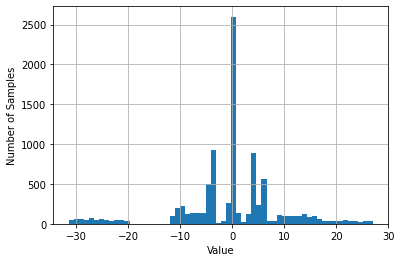

In [40]:
# samples pzt after oversampling
X = smoteDF.drop(['PZT'], axis=1).values
Y = smoteDF['PZT'].values
smoteDF['PZT'].hist(bins = 60)
plt.xlabel('Value')
plt.ylabel('Number of Samples')

Text(0, 0.5, 'Number of Samples')

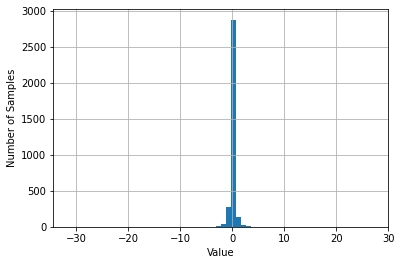

In [41]:
# samples pzt before oversampling
df['PZT'].hist(bins = 60)
plt.xlabel('Value')
plt.ylabel('Number of Samples')

In [ ]:
#smotedf train and test split
X_train, X_test, y_train, y_test = train_test_split (X, Y, test_size=0.2, random_state=0)
sets = [X_train, X_test, y_train, y_test]

In [ ]:
# exporting smoted dataset for consistency
from google.colab import files
dwnlds = {"x1.csv": X_train, "x2.csv": X_test, "y1.csv": y_train, "y2.csv": y_test}
for name, data in dwnlds.items():
  pd.DataFrame(data).to_csv(name, index=False)
  files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
#train and test split and standardization for non smote dataset
x2 = clnDF.drop(['PZT'], axis=1).values
y2 = clnDF['PZT'].values

X_train2, X_test2, y_train2, y_test2 = train_test_split (x2, y2, test_size=0.2, random_state=0)

sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

testx = X_test2[round(len(X_test2)/3):]
valix = X_test2[:round(len(X_test2)/3):]
testy = y_test2[round(len(y_test2)/3):]
valiy = y_test2[:round(len(y_test2)/3)]

In [55]:
#err func to see if predictions are within error margin
def errMrginAcc(p, y):
  perc = 10

  yes = []
  no = []
  
  for i in range(len(y)):

    margin = np.abs(y[i] / perc)
    upper = y[i] + margin
    lower = y[i] - margin

    if p[i] > lower and p[i] < upper:
      yes.append(y[i])
    else:
      no.append(y[i])

  return [len(yes)/len(y), yes, no]


In [56]:
print(X_train2.shape,y_train2.shape)

(2473, 45) (2473,)


0.23913250080044862


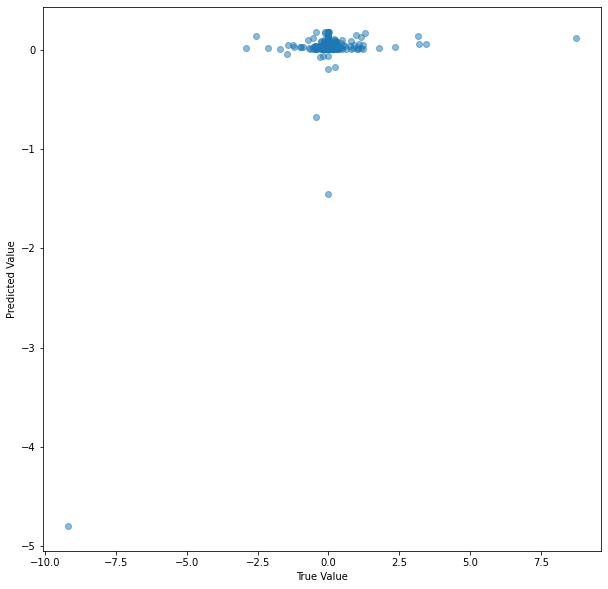

In [60]:
# testing training ANN with non smote data
ANN = ANN = tf.keras.models.Sequential()
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=45, activation=tf.keras.activations.gelu))
ANN.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear))
ANN.compile(loss = tf.keras.losses.mse, 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['mse'])


# training ANN
ANN.fit(X_train2,y_train2, batch_size=50,epochs=130, verbose=0)

prd_y = ANN.predict(testx)
print(mean_absolute_error(testy, prd_y))

plt.figure(figsize=(10, 10))
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.scatter(testy, prd_y, alpha = 0.5)

Further Modeling and Visualizing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fdd80cd50>,
      dtype=object)

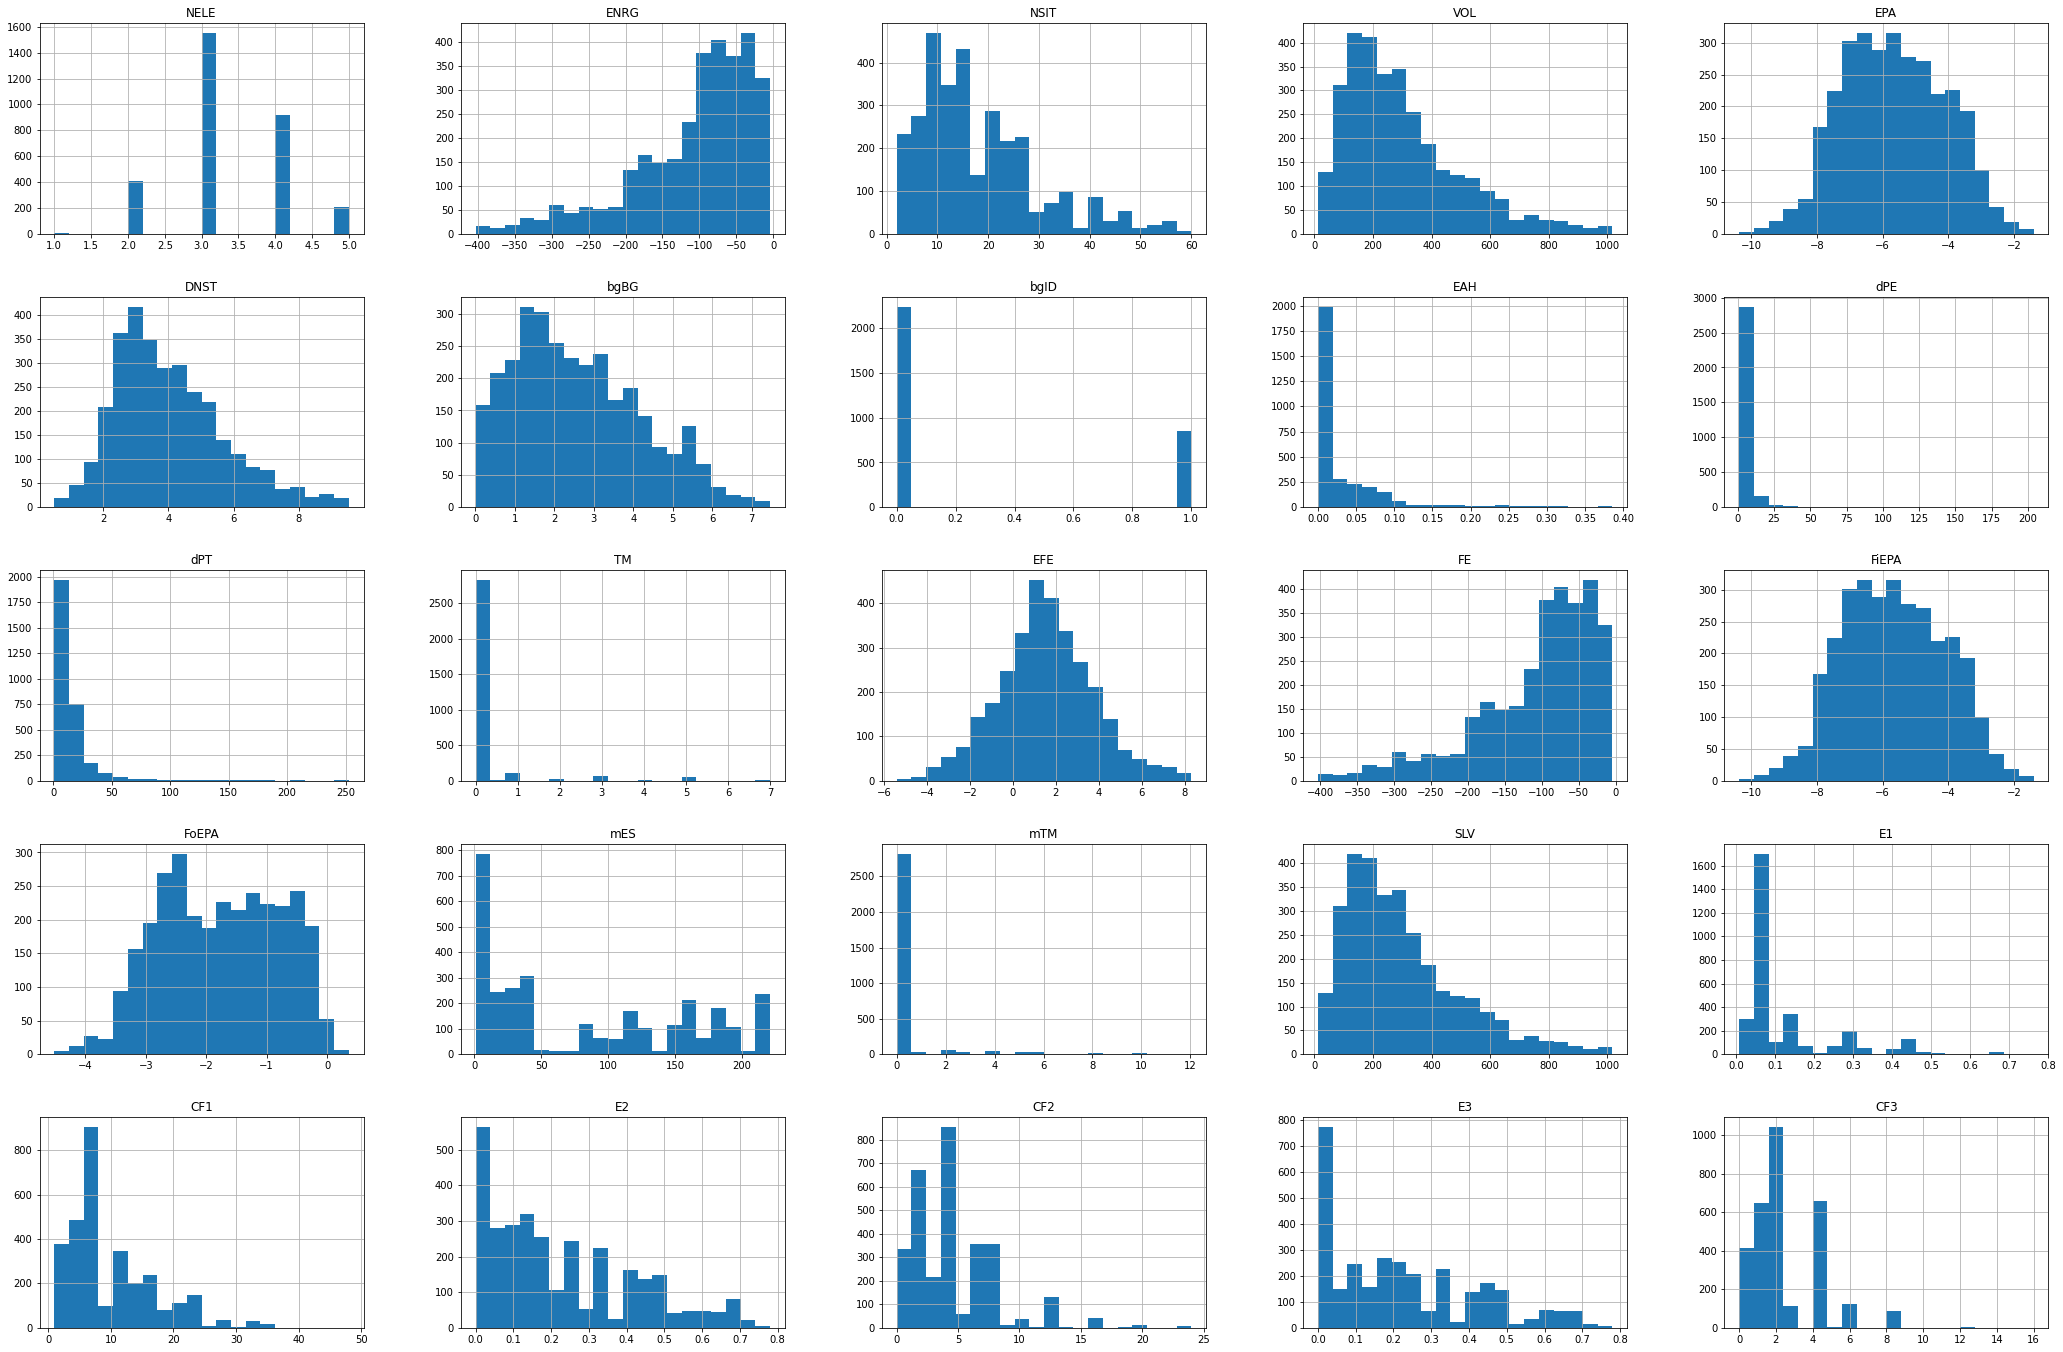

In [ ]:
fig, axis = plt.subplots(5, 5,figsize=(36, 24))
clnDF[list(num + exc)].hist(ax=axis, bins=20)

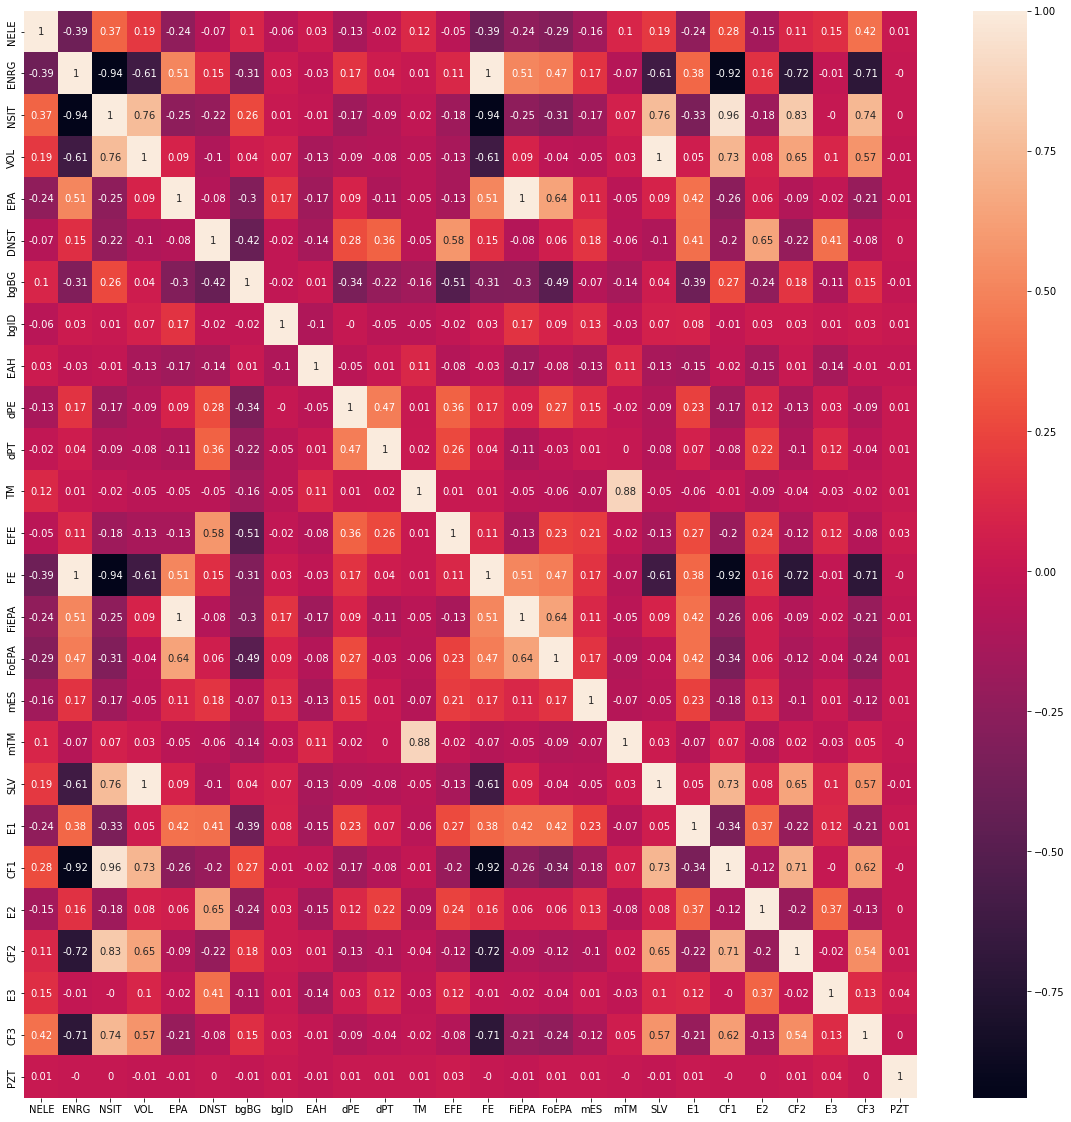

In [ ]:
correlation_matrix = clnDF[list(num + exc + tgt)].corr().round(2)
fig, ax = plt.subplots(figsize=(20,20))    
sns.heatmap(data=correlation_matrix, annot=True, ax=ax)
